In [1]:
import math
import os
import pickle
from collections import defaultdict, namedtuple
from scipy.stats import poisson
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from IPython.display import clear_output
from matplotlib import animation
import numpy as np

Defining problem parameters:


In [2]:
MAX_CARS = 20
MAX_MOVE = 5

LAMBDA_RENT_1 = 3
LAMBDA_RENT_2 = 4
LAMBDA_RETURN_1 = 3
LAMBDA_RETURN_2 = 2

RENT_CREDIT = 10
MOVE_COST = 2

GAMMA = 0.9

PROB_THRESHOLD = 1e-6

THETA = 1e-3

Defining state and action spaces:


In [3]:
state = namedtuple("state", ["cars_1", "cars_2"])
S = [
    state(cars_1=cars_1, cars_2=cars_2)
    for cars_1 in range(MAX_CARS + 1)
    for cars_2 in range(MAX_CARS + 1)
]
A = list(range(-MAX_MOVE, MAX_MOVE + 1))

print("S:", S[:2], "...")
print("A:", A)

S: [state(cars_1=0, cars_2=0), state(cars_1=0, cars_2=1)] ...
A: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


We enumerate all events, where an event is a tuple of the form (requests_1, requests_2, returns_1, returns_2), where requests_1 and requests_2 are the number of cars requested at location 1 and 2, respectively, and returns_1 and returns_2 are the number of cars returned at location 1 and 2, respectively. We then compute the probability of each event.

Finally, for computational efficiency, we truncate the event space to those events with probability exceeding a user-defined threshold.


In [4]:
# enumerate all possible request and return events
realizations = np.array(
    [
        [i, j, k, l]
        for i in range(MAX_CARS + 1)
        for j in range(MAX_CARS + 1)
        for k in range(MAX_CARS + 1)
        for l in range(MAX_CARS + 1)
    ]
)

# compute poisson probabilities for all possible rental requests and returns
probs = poisson.pmf(
    realizations, [LAMBDA_RENT_1, LAMBDA_RENT_2, LAMBDA_RETURN_1, LAMBDA_RETURN_2]
).prod(axis=1)
probs = {tuple(realizations[i, :]): probs[i] for i in range(realizations.shape[0])}
print("Event probabilities:", list(probs.items())[:2], "...")

# remove all events with probability below threshold
probs_clipped = {k: v for k, v in probs.items() if v > PROB_THRESHOLD}
print(f"Compression ratio: {len(probs_clipped) / len(probs):.3%}")

Event probabilities: [((0, 0, 0, 0), 6.144212353328207e-06), ((0, 0, 0, 1), 1.2288424706656418e-05)] ...
Compression ratio: 4.255%


Constructing the table $p(s',r | s,a)$. For each state $s$ and action $a$, we compute the probability of each possible next state $s'$ and reward $r$ (considered as a pair).

This step is the most computationally intensive, so the results are cached to disk.


In [5]:
def is_valid(s: state, a: int) -> bool:
    """
    Check if it is possible to move 'a' cars from location 1 to location 2.

    Note: The problem states there can be no more than 20 cars at each
    location. However in the second plot (p. 81), we see policy pi_1 takes
    action 1 where there are 20 cars at both locations: i.e., it moves a car
    from location 1 to location 2, so that the latter has 21 cars.

    We thus allow the number of cars at each location to exceed 20, but we
    will clip the number of cars at each location to 20 when computing the
    reward and next state.
    """
    if a > 0:
        return (s.cars_1 - a) >= 0
    elif a < 0:
        return (s.cars_2 + a) >= 0
    else:
        return True


def generate_model():
    p = defaultdict(float)
    for s in S:
        print(s, end="\r")
        for a in A:
            # remove illegal actions
            if not is_valid(s, a):
                continue

            p_sa = defaultdict(float)
            # Move cars
            s_prime = state(cars_1=s.cars_1 - a, cars_2=s.cars_2 + a)
            move_cost = MOVE_COST * abs(a)

            for (
                request_1,
                request_2,
                return_1,
                return_2,
            ), prob in probs_clipped.items():

                # Identify the number of cars rented
                rented_1 = min(s_prime.cars_1, request_1)
                rented_2 = min(s_prime.cars_2, request_2)

                # Update the number of cars at each location after rentals
                n_cars_1 = min(MAX_CARS, s_prime.cars_1 - rented_1)
                n_cars_2 = min(MAX_CARS, s_prime.cars_2 - rented_2)

                # Identify the number of cars returned
                returned_1 = min(return_1, MAX_CARS - n_cars_1)
                returned_2 = min(return_2, MAX_CARS - n_cars_2)

                # Update the number of cars at each location after returns
                n_cars_1 = n_cars_1 + returned_1
                n_cars_2 = n_cars_2 + returned_2

                s_prime_ = state(cars_1=n_cars_1, cars_2=n_cars_2)
                r = (rented_1 + rented_2) * RENT_CREDIT - move_cost
                p_sa[(s_prime_, r)] += prob

            p[(s, a)] = p_sa
    return p


# REGENERATE = False
# if os.path.exists("data/model.pkl") is False or REGENERATE:
#     p = generate_model()
#     with open("data/model.pkl", "wb") as f:
#         pickle.dump(p, f)
# else:
#     with open("data/model.pkl", "rb") as f:
#         p = pickle.load(f)
p = generate_model()

Defining the policy evaluation and improvement functions, as well as rendering functions for visualizing the policy and value function.


In [6]:
def render_value_function(
    values: dict[state, float],
    title: str = "",
):
    value_array = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    for s, v in values.items():
        value_array[s.cars_1, s.cars_2] = v

    img = plt.imshow(value_array, cmap="viridis", origin="lower")
    plt.title(title)
    plt.xlabel("# Cars at second location")
    plt.ylabel("# Cars at first location")
    return img


def render_policy(
    values: dict[state, float],
    title: str = "",
    save: bool = False,
):
    value_array = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    for s, v in values.items():
        value_array[s.cars_1, s.cars_2] = v
    cmap = plt.get_cmap("viridis", len(np.unique(value_array)))
    norm = colors.BoundaryNorm(A, cmap.N)
    plot = plt.imshow(value_array, cmap=cmap, origin="lower")
    plt.colorbar()
    plt.xlabel("# Cars at second location")
    plt.ylabel("# Cars at first location")
    plt.title(title)
    if save:
        plt.savefig(f"images/{title}.png")
    plt.show()


def evaluate():
    n_iter = 0
    delta = 0
    theta = THETA
    n_iter = 0
    while delta >= theta or n_iter == 0:
        print(f"Policy Evaluation: {n_iter}, delta: {delta}", end="\r")
        delta = 0
        for s in S:  # in-place update
            v = V[s]
            a = pi[s]
            V[s] = sum(
                [
                    prob * (r + GAMMA * V[s_prime])
                    for (s_prime, r), prob in p[s, a].items()
                ]
            )
            delta = max(delta, abs(v - V[s]))
        n_iter += 1


def improve():
    policy_stable = True
    for s in S:
        old_action = pi[s]
        max_v = -math.inf
        for a in A:
            if not is_valid(s, a):
                continue
            v = sum(
                [
                    prob * (r + GAMMA * V[s_prime])
                    for (s_prime, r), prob in p[s, a].items()
                ]
            )
            if v >= max_v:
                max_v = v
                pi[s] = a
        if old_action != pi[s]:
            policy_stable = False
    return policy_stable

Policy Iteration Loop:


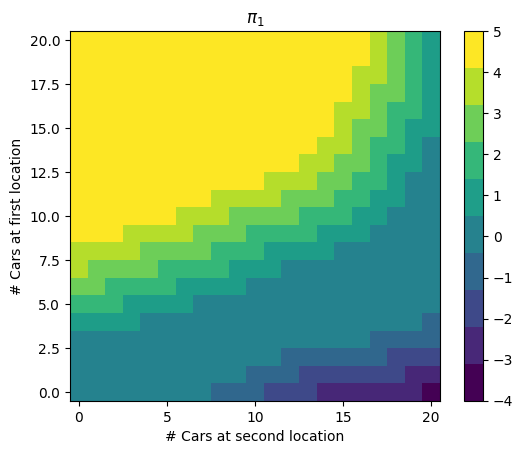

# Policy Iterations: 0


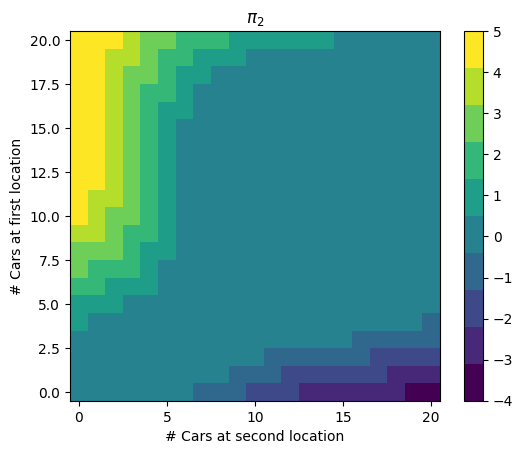

# Policy Iterations: 1


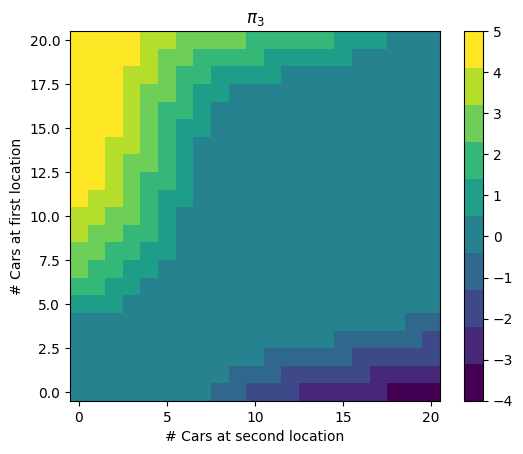

# Policy Iterations: 2


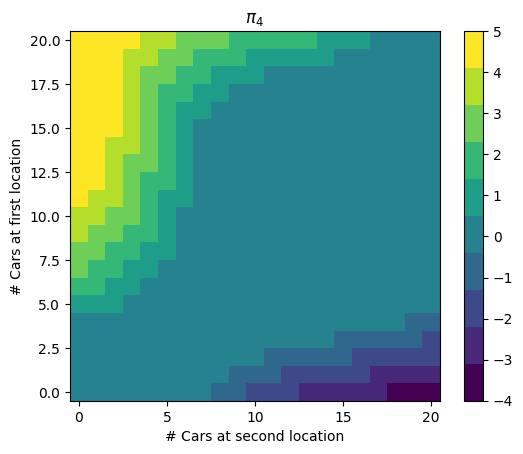

# Policy Iterations: 3


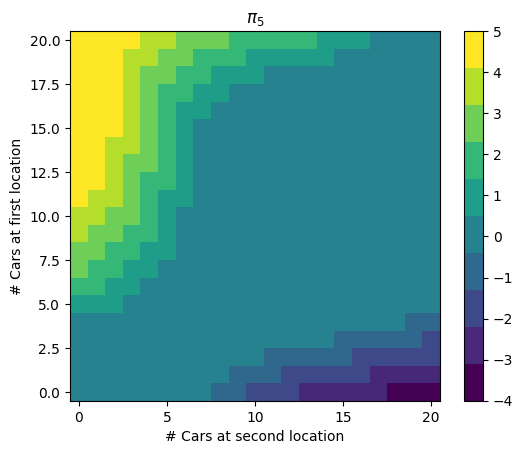

# Policy Iterations: 4


In [8]:
V = {s: 0 for s in S}
pi = {s: 0 for s in S}
gamma = 0.9
policy_stable = False
n_policy_iterations = 0
while policy_stable is False:
    evaluate()
    policy_stable = improve()
    render_policy(pi, title=f"$\pi_{n_policy_iterations + 1}$", save=False)
    print("# Policy Iterations:", n_policy_iterations)
    n_policy_iterations += 1